## 是否考虑Q2和Q3的模型继承性？

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=16)  # 这里假设SimSun字体路径，根据实际情况调整

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题


def preprocess_data(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X = pd.get_dummies(X, drop_first=True)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    accuracy = cv_scores.mean()
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    f1 = cross_val_score(model, X, y, cv=5, scoring='f1').mean()
    
    # Calculate Type I and Type II errors
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    type1_error = fp / (fp + tn)
    type2_error = fn / (fn + tp)
    
    return accuracy, auc, f1, type1_error, type2_error

def analyze_dataset(df, target_column, dataset_name):
    X, y = preprocess_data(df, target_column)
    
    models = {
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        '决策树': DecisionTreeClassifier(),
        '随机森林': RandomForestClassifier(),
        'SVM': SVC(probability=True)
    }
    
    results = []
    
    for model_name, model in models.items():
        accuracy, auc, f1, type1_error, type2_error = evaluate_model(model, X, y)
        results.append({
            'Dataset': dataset_name,
            '模型': model_name,
            '精确度': accuracy,
            'AUC': auc,
            'F1-分数': f1,
            '第一类错误': type1_error,
            '第二类错误': type2_error
        })
    
    return pd.DataFrame(results)

# Load datasets
german_df = pd.read_csv('..\Data\data1.csv')
australian_df = pd.read_csv('..\Data\data2.csv')

# Analyze German Credit Dataset
german_results = analyze_dataset(german_df, 'Y(1=default, 0=non-default)', 'German Credit')

# Analyze Australian Credit Dataset
australian_results = analyze_dataset(australian_df, 'Y(1=default, 0=non-default)', 'Australian Credit')

# Combine results
all_results = pd.concat([german_results, australian_results])

# Display results
print(all_results.to_string(index=False))



In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, make_scorer
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import GridSearchCV

# def preprocess_data(df, target_column):
#     X = df.drop(target_column, axis=1)
#     y = df[target_column]
#     X = pd.get_dummies(X, drop_first=True)
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
#     return X_scaled, y

# def custom_f1_score(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     precision = tp / (tp + fp)
#     recall = tp / (tp + fn)
#     f1 = 2 * (precision * recall) / (precision + recall)
#     return f1

# def evaluate_model(model, X, y):
#     cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
#     accuracy = cv_scores.mean()
#     auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
#     f1 = cross_val_score(model, X, y, cv=5, scoring=make_scorer(custom_f1_score)).mean()
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#     type1_error = fp / (fp + tn)
#     type2_error = fn / (fn + tp)
    
#     return accuracy, auc, f1, type1_error, type2_error

# def optimize_xgboost(X, y):
#     # 计算类别权重
#     class_weights = dict(zip(np.unique(y), len(y) / (len(np.unique(y)) * np.bincount(y))))
    
#     # 使用SMOTE过采样
#     smote = SMOTE(random_state=42)
#     X_resampled, y_resampled = smote.fit_resample(X, y)
    
#     # 设置参数网格
#     param_grid = {
#         'max_depth': [3, 4, 5],
#         'learning_rate': [0.01, 0.1, 0.3],
#         'n_estimators': [100, 200, 300],
#         'min_child_weight': [1, 3, 5],
#         'gamma': [0, 0.1, 0.2],
#         'subsample': [0.8, 0.9, 1.0],
#         'colsample_bytree': [0.8, 0.9, 1.0]
#     }
    
#     # 初始化XGBoost模型
#     xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=class_weights[1])
    
#     # 使用GridSearchCV进行参数优化
#     grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
#     grid_search.fit(X_resampled, y_resampled)
    
#     # 获取最佳模型
#     best_model = grid_search.best_estimator_
    
#     return best_model

# # 加载德国信用数据集
# german_df = pd.read_csv('../Data/data_1.csv')

# # 预处理数据
# X, y = preprocess_data(german_df, 'Y(1=default, 0=non-default)')

# # 优化XGBoost模型
# optimized_xgb = optimize_xgboost(X, y)

# # 评估优化后的模型
# accuracy, auc, f1, type1_error, type2_error = evaluate_model(optimized_xgb, X, y)

# print("Optimized XGBoost Results:")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"AUC: {auc:.4f}")
# print(f"F1-score: {f1:.4f}")
# print(f"Type I Error: {type1_error:.4f}")
# print(f"Type II Error: {type2_error:.4f}")

### 结果可视化及数据存储

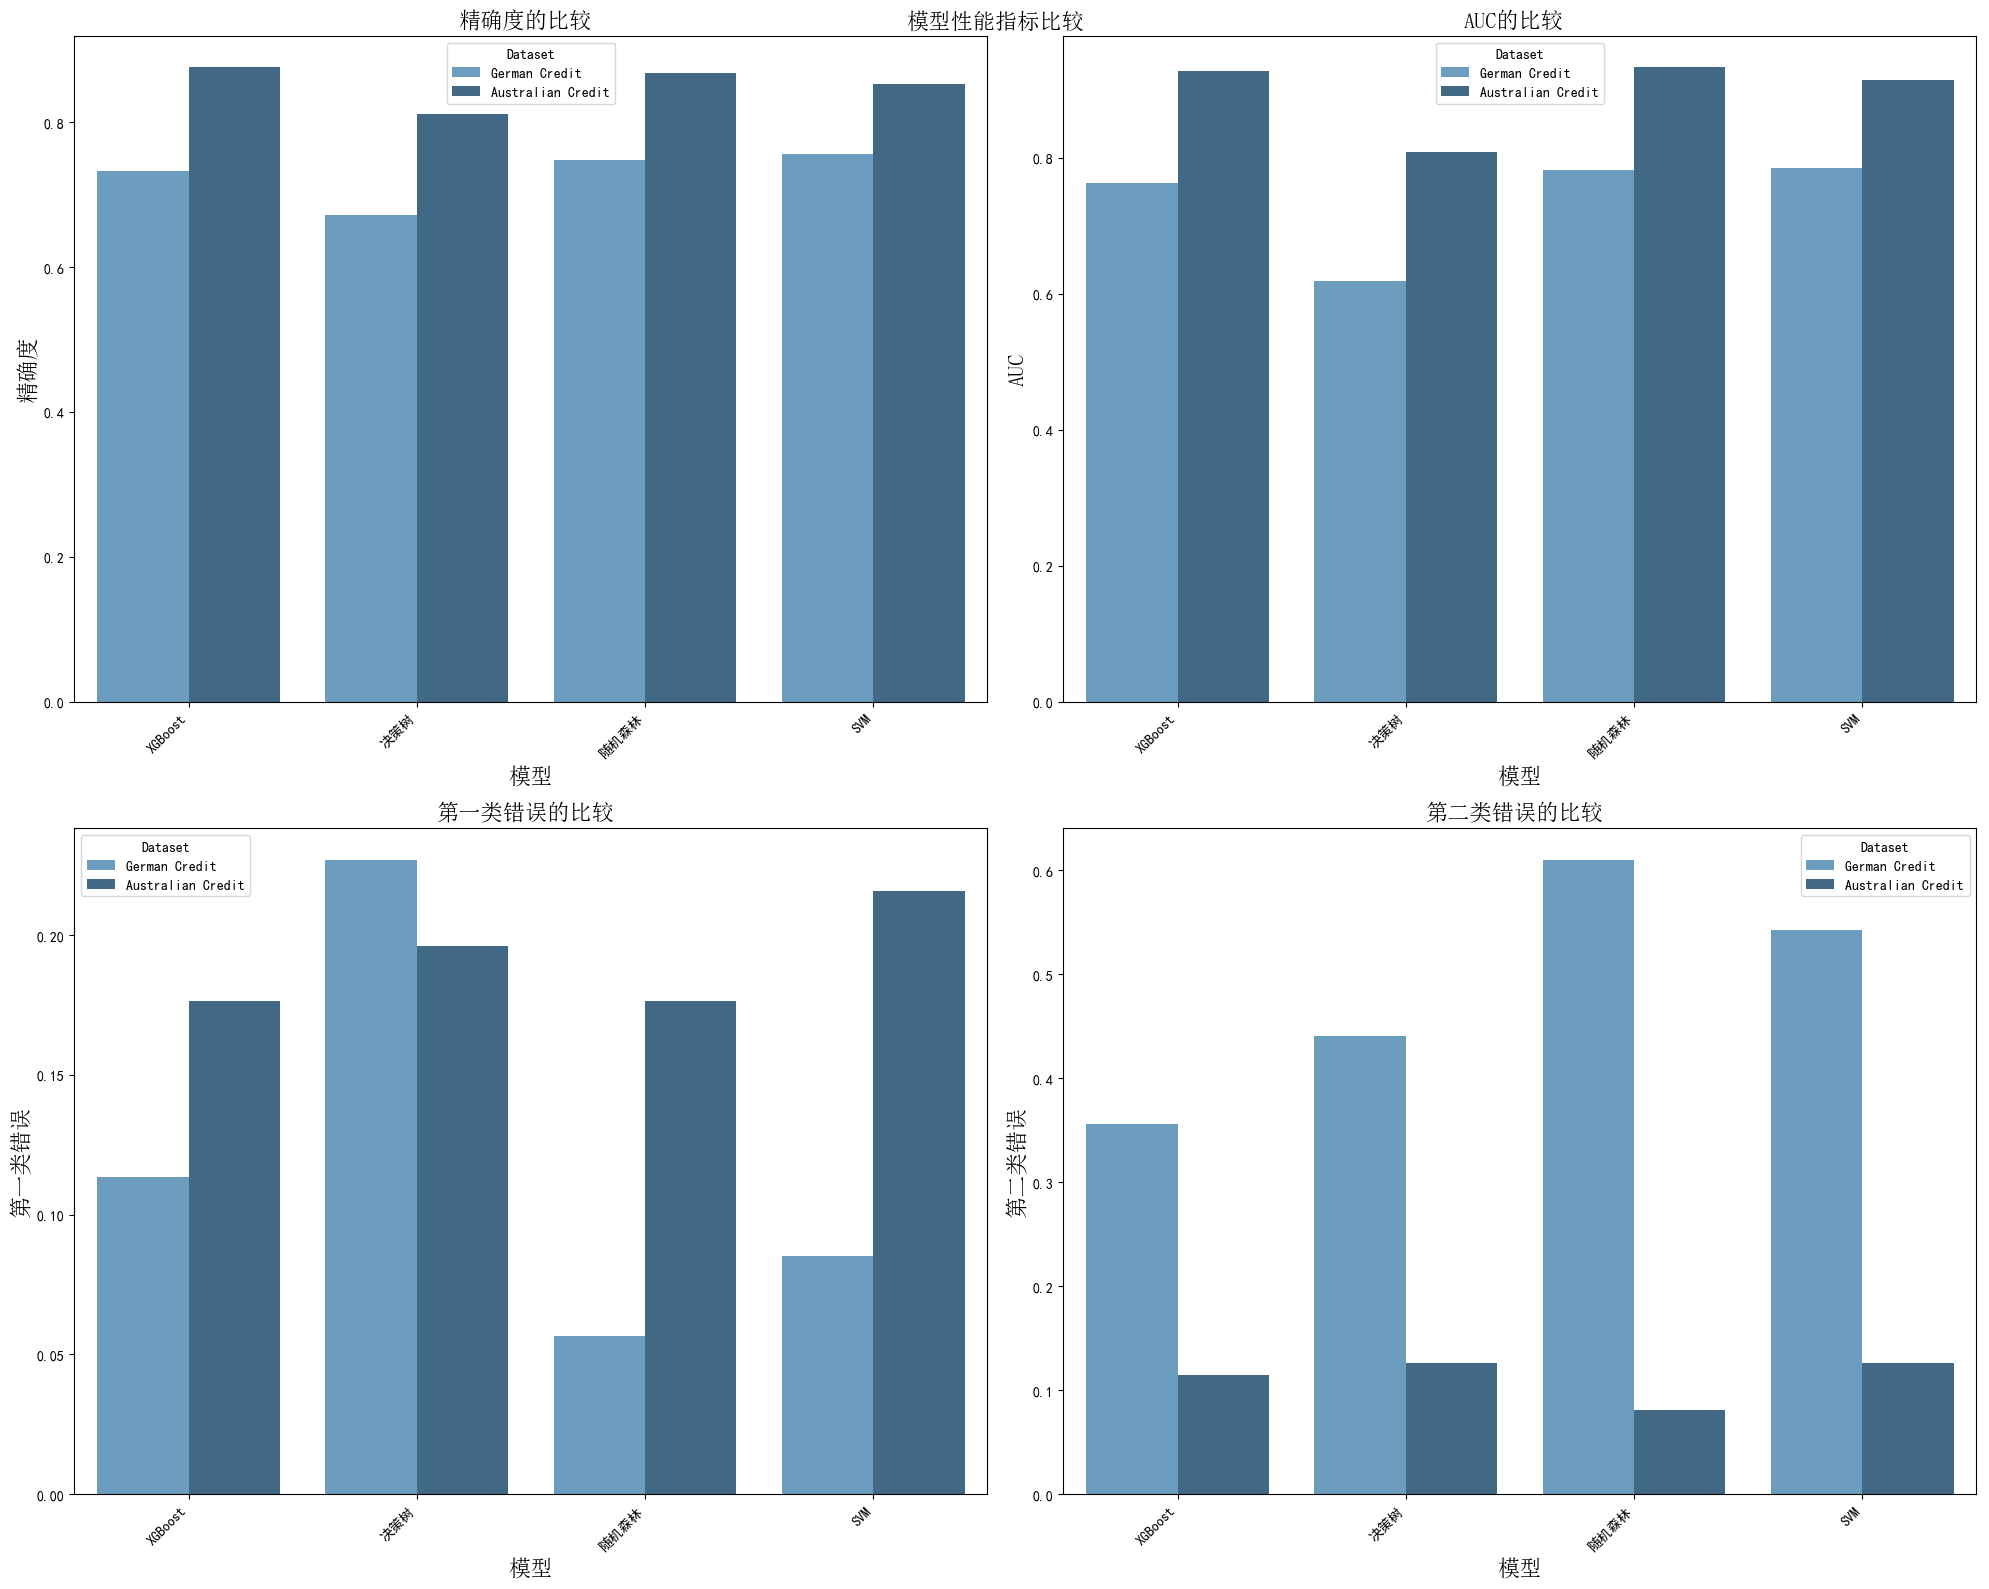


Results saved to 'Q3_credit_model_comparison_results.csv'
Visualization saved to 'Q3_Performance_Metrics_Comparison.png'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 all_results 是包含所有结果的 DataFrame

# 创建一个 2x2 的子图
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('模型性能指标比较',fontproperties=font,y=0.99)

# 定义要绘制的指标和它们的位置
metrics = [
    ('精确度', axs[0, 0]),
    ('AUC', axs[0, 1]),
    ('第一类错误', axs[1, 0]),
    ('第二类错误', axs[1, 1])
]

# 为每个指标创建一个子图
for metric, ax in metrics:

    # 需要蔺经纬同志调配色！
    sns.barplot(x='模型', y=metric, hue='Dataset', data=all_results, ax=ax,palette='Blues_d')
    # 需要蔺经纬同志调配色！
    
    ax.set_title(f'{metric}的比较 ',fontproperties=font)
    ax.set_xlabel('模型',fontproperties=font)
    ax.set_ylabel(metric,fontproperties=font)
    ax.legend(title='Dataset')
    
    # 调整 x 轴标签的角度，以防止重叠
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('..\Data\Q3_Performance_Metrics_Comparison.png')
plt.show()

# Save results to CSV
all_results.to_csv('..\Data\Q3_credit_model_comparison_results.csv', index=False)
print("\nResults saved to 'Q3_credit_model_comparison_results.csv'")
print("Visualization saved to 'Q3_Performance_Metrics_Comparison.png'")